In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

from unidip.dip import diptst

sys.path.append("..")
from util.plot import Background, add_panel_letters

%matplotlib inline

In [2]:
df = pd.read_pickle("../run/Taa/df-grouped-rec.pkl")

In [3]:
xo = df[['tdur', 'tfr_slope', 'tfr_r2', 'pca_ve1', 'pca_ve2ac']].values

x = np.copy(xo)
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

In [4]:
maxn = 10
silhouettes = np.full(maxn, np.nan)
ssds = np.full(maxn, np.nan)
chs = np.full(maxn, np.nan)

for i in range(1, maxn+1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit_transform(x)
    labels = kmeans.labels_
    
    if i > 1:
        silhouettes[i-1] = silhouette_score(x, labels)
        chs[i-1] = calinski_harabasz_score(x, labels)
    ssds[i-1] = kmeans.inertia_

In [5]:
ncl = 5
kmeans = KMeans(n_clusters=ncl)
kmeans.fit_transform(x)
labels = kmeans.labels_

## Figure

In [6]:
def plot_kde(gs, df):
    variables = ['tdur',         'tfr_slope',     'tfr_r2',      'pca_ve1',   'pca_ve2ac']
    labels =    ["Duration [s]",  "Slope [mm/s]",       "R$^2$",       "PCA VE1",   "PCA VE2"]
    limits =    [(0, 20),     (-0.05, 0.65), (-0.05, 1.05), (0.38, 1.02), (0.79, 1.01)]
    ylims =     [(1e-3, 1e0), (1e-1, 1e2),   (1e-2, 1e1),   (1e-1, 1e2), (1e-1, 1e2)]
    
    for i, var in enumerate(variables):
        ax = plt.subplot(gs[i])
        lim = limits[i]

        for bw in [0.2, 0.5, 0.8]:
            df[var].plot(kind='density', ind=np.linspace(lim[0], lim[1], 1000), lw=2, zorder=5,
                         bw_method=bw, label=bw)

        plt.xlabel(labels[i], fontsize=12)
        plt.yscale('log')
        plt.ylim(ylims[i])
        plt.ylabel("")

        plt.scatter(df[var], ylims[i][0]*np.ones(len(df)), marker=2, color='k', s=100, linewidth=0.6)

        if i == 1:
            plt.legend(loc='upper right', title="Factor")

        # Dip statistics
        dip, pval, intervals = diptst(df[var])
        plt.text(0.03, 0.85, f"$p = {pval:.3f}$", transform=plt.gca().transAxes, fontsize=12)    

In [7]:
def secder(x):
    return np.concatenate([[np.nan], (x[2:] - 2*x[1:-1] + x[:-2]), [np.nan]])

def set_color(ax, color):
    # ax.spines['left'].set_color(color)
    # ax.spines['right'].set_color(color)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='y', colors=color)    

def plot_nclusters(gs, ssds, silhouettes, chs):
    maxn = len(ssds)+1
    
    ax1a = plt.subplot(gs[0])
    plt.plot(np.r_[1:maxn], ssds, 'bx-')
    set_color(ax1a, 'b')
    plt.xlabel("Number of clusters", fontsize=12)
    plt.ylabel("SSD", fontsize=12)
    
    ax1b = plt.twinx()
    plt.plot(np.r_[1:maxn],secder(ssds), 'rx-')
    plt.xticks(np.r_[1:maxn])
    plt.axvline(5, color='k', ls='--')
    set_color(ax1b, 'r')
    plt.ylabel("Second derivative\nof SSD", fontsize=12)
    
    ax2a = plt.subplot(gs[1])
    plt.plot(np.r_[1:maxn], silhouettes, 'bx-')
    plt.xticks(np.r_[1:maxn])
    set_color(ax2a, 'b')
    plt.xlabel("Number of clusters", fontsize=12)
    plt.ylabel("Silhouette score", fontsize=12)
    
    ax2b = plt.twinx()
    plt.plot(np.r_[1:maxn], chs, 'rx-')
    plt.axvline(5, color='k', ls='--')
    set_color(ax2b, 'r')
    plt.ylabel("Calinski-Harabasz\nscore", fontsize=12)

In [8]:
cluster_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']

def plot_clusters(gs, x, labels, ncl):
    names = ["Duration",  "Slope", "R$^2$", "PCA VE1", "PCA VE2"]

    for i in range(ncl):
        plt.subplot(gs[i])
        plt.title(f"Cluster {i+1}")
        plt.plot(x.T, '-', lw=0.5, alpha=0.3, color='k')
        mask = (labels == i)
        plt.plot(x[mask].T, '-', color=cluster_colors[i])
        plt.xticks(np.r_[:5], names, rotation='vertical')
        plt.ylabel("z-score", fontsize=12)
        plt.ylim(-3.5, 3.5)

In [9]:
def remove_borders(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', length=0)

def plot_subjects(ax, df, labels):
    plt.sca(ax)
    ax.set_aspect('equal')
    
    ticks = []
    ticklabels = []
    circles = []
    
    ypos = 0
    for subject in df.subject.unique():
        posmin = ypos
        
        dff = df[df.subject == subject]
        for rec in dff.rec.unique():
            dfff = dff[dff.rec == rec]
            for xpos, (i, row) in enumerate(dfff.iterrows()):
                circle = matplotlib.patches.Circle((xpos,ypos), 0.45,
                                                   facecolor=cluster_colors[labels[i]], edgecolor='k')
                ax.add_artist(circle)
            
            ypos += 1
        posmax = ypos-1
        
        plt.plot([-0.9, -0.9], [posmin-0.4, posmax+0.4], color='k')
        ticks.append((posmin+posmax)/2.)
        ticklabels.append(int(subject[2:]))
        
        ypos += 1
                
    plt.yticks(ticks, ticklabels)
    plt.xticks([])
    plt.xlim(-1, 3)
    plt.ylim(ypos-1.2, -0.8)
    
    remove_borders(ax)


## Multimodality figure

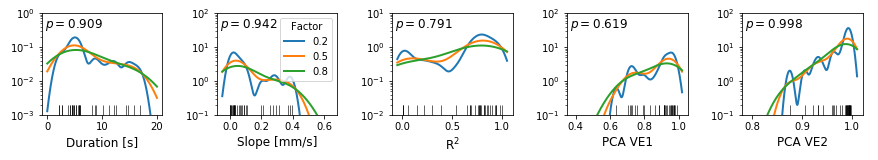

In [10]:
plt.figure(figsize=(12,2))
gs = GridSpec(1, 5, left=0.04, right=0.99, top=0.96, bottom=0.25, wspace=0.45)
plot_kde(gs, df)

bg = Background(visible=False)
plt.savefig("figs/multimodality.pdf")

## Clustering figure

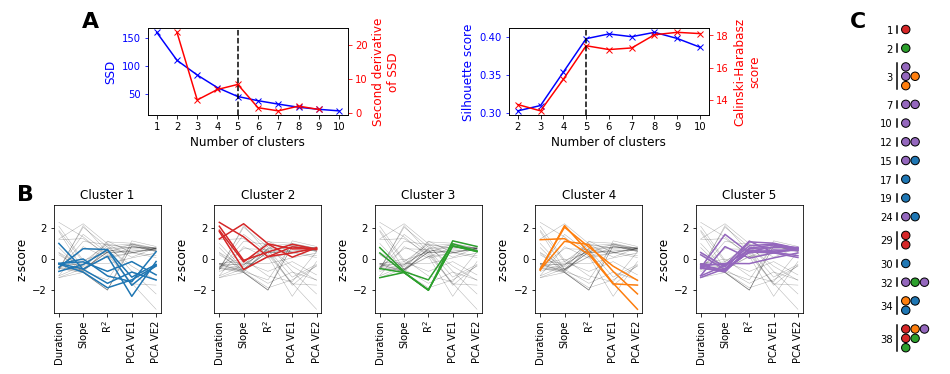

In [11]:
fig = plt.figure(figsize=(13, 5))

# Panel A: Number of clusters
gsA = GridSpec(1, 2, wspace=0.8, left=0.15, right=0.75, top=0.94, bottom=0.70)
plot_nclusters(gsA, ssds, silhouettes, chs)

# Panel B: Clusters
gsB = GridSpec(1, 5, wspace=0.5, left=0.05, right=0.85, top=0.45, bottom=0.15)
plot_clusters(gsB, x, labels, ncl)

# Panel C: Individual seizures
gsC = GridSpec(1, 1, left=0.95, right=0.99, top=0.98, bottom=0.01)
plot_subjects(plt.subplot(gsC[0]), df, labels)

bg = Background(visible=False)
bg.labels([0.08, 0.01, 0.9], [0.93, 0.45, 0.93], fontsize=22)

plt.savefig("figs/clustering.pdf")